# Прогнозирование удоя и вкуса молока коров с помощью машинного обучения

## Цели исследования:

- **Анализ данных**: Работа с тремя датасетами, содержащими данные о стаде фермера, для создания моделей и данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.
- **Разработка моделей**: Создание двух прогнозных моделей машинного обучения для отбора бурёнок в поголовье. Первая модель будет прогнозировать возможный удой коровы, вторая - рассчитывать вероятность получить вкусное молоко от коровы.
- **Отбор коров**: С помощью моделей отобрать коров по двум критериям: средний удой за год должен быть не менее 6000 килограммов, а молоко должно быть вкусным.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from IPython.display import clear_output
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error, 
                             r2_score,accuracy_score, 
                             recall_score, 
                             precision_score, 
                             confusion_matrix,
                             f1_score
)
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

## Загрузка данных

In [2]:
# Загрузка данных из файла ferma_main.csv
df_main = pd.read_csv('datasets\\ferma_main.csv', delimiter=';')

# Загрузка данных из файла ferma_dad.csv
df_dad = pd.read_csv('datasets\\ferma_dad.csv', delimiter=';')

# Загрузка данных из файла cow_buy.csv
df_cow = pd.read_csv('datasets\\cow_buy.csv', delimiter=';')

In [3]:
# Объединение df_main и df_dad по столбцу id
df_merged = pd.merge(df_main, df_dad, on='id')


In [4]:
# Функция для изучения данных
def explore_data(df):
    # Просмотр первых пяти строк датафрейма
    display(df.head(20))
    # Просмотр общей информации о датафрейме
    display(df.info())
    # Просмотр статистических характеристик количественных признаков в датафрейме
    display(df.describe())
    # Просмотр уникальных значений категориальных признаков в датафрейме
    for column in df.select_dtypes(include=['object']).columns:
        display(df[column].value_counts())

# Изучение данных
explore_data(df_merged)
explore_data(df_cow)


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет,Буйный
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет,Соловчик
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет,Барин
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет,Буйный
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет,Барин
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет,Барин
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет,Соловчик
7,8,6179,"14,7",1806,"0,93",Вис Бик Айдиал,Равнинные,Айдиал,"3,55","3,076",вкусно,более_2_лет,Геркулес
8,9,6783,"14,2",1918,"0,94",РефлешнСоверинг,Холмистое,Айдиал,"3,71","3,077",вкусно,более_2_лет,Буйный
9,10,5339,"13,4",1791,"0,895",Вис Бик Айдиал,Холмистое,Соверин,"3,13","3,075",вкусно,менее_2_лет,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

None

,id,"Удой, кг","Сырой протеин, г"
count,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,1922.682965
std,183.096982,1638.401021,182.392548
min,1.000000,5204.000000,1660.000000
25%,159.250000,5751.750000,1772.250000
50%,317.500000,6130.500000,1880.500000
75%,475.750000,6501.000000,2058.750000
max,629.000000,45616.000000,2349.000000


ЭКЕ (Энергетическая кормовая единица)
14,7    27
15,7    24
15,6    23
14,6    23
14,4    20
15,8    19
15,2    18
14,2    18
15,3    18
15,5    17
16,4    17
13,2    16
14,9    16
15,1    16
13,4    16
14,1    15
13,9    15
16,2    15
16,3    15
15,4    15
16,5    14
15,9    14
14,8    14
13,5    14
13,7    14
13,1    13
13,8    13
12,9    12
12,8    11
13,6    10
16,1    10
16,7    10
13,3    10
14,5    10
11,9     9
12,7     9
14,3     9
12,4     8
12,3     8
14       7
12,5     7
15       6
16,6     6
11,8     6
12,1     5
12,2     5
12,6     5
16,8     3
13       2
16       2
11,5     1
12       1
11,1     1
11,7     1
10,9     1
Name: count, dtype: int64

СПО (Сахаро-протеиновое соотношение)
0,94     172
0,93     141
0,89      94
0,88      63
0,95      55
0,84      25
0,86      25
0,895     23
0,85      17
0,885     15
0,96       3
0,9        1
Name: count, dtype: int64

Порода
Вис Бик Айдиал     373
РефлешнСоверинг    261
Name: count, dtype: int64

Тип пастбища
Холмистое    356
Равнинное    253
Равнинные     25
Name: count, dtype: int64

порода папы_быка
Соверин    316
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

Жирность,%
3,72    112
3,73     78
3,71     78
3,64     41
3,63     37
3,61     35
3,62     31
3,59     25
3,65     19
3,74     16
3,7      13
3,58     11
3,27     10
3,42     10
3,18      9
3,48      8
3,34      7
3,33      7
3,57      7
3,49      7
3,53      6
3,21      6
3,28      5
3,44      5
3,22      4
3,26      4
3,13      4
2,99      3
3,12      3
3,11      3
3,25      3
3,38      3
3,31      2
3,55      2
3,37      2
3,01      2
3,41      2
3,16      2
3,75      1
3,23      1
3,39      1
3,24      1
3,15      1
3,4       1
3,32      1
3,35      1
3,54      1
3,69      1
3,03      1
3,19      1
Name: count, dtype: int64

Белок,%
3,076    103
3,075     95
3,077     79
3,074     73
3,078     67
3,073     59
3,079     50
3,072     38
3,08      22
3,071     21
3,081     11
3,07      11
3,082      2
3,085      2
3,069      1
Name: count, dtype: int64

Вкус молока
вкусно       371
не вкусно    263
Name: count, dtype: int64

Возраст
более_2_лет    524
менее_2_лет    110
Name: count, dtype: int64

Имя Папы
Барин       245
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,59","3,074",более_2_лет
freq,11,11,12,8,3,5,15


Порода
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

Тип пастбища
равнинное    11
холмистое     9
Name: count, dtype: int64

порода папы_быка
Соверин    12
Айдиал      8
Name: count, dtype: int64

Имя_папы
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64

Текущая_жирность,%
3,59    3
3,4     3
3,73    3
3,58    2
3,64    2
3,54    1
3,63    1
3,57    1
3,68    1
3,42    1
3,77    1
3,34    1
Name: count, dtype: int64

Текущий_уровень_белок,%
3,074    5
3,079    3
3,076    2
3,053    2
3,081    1
3,061    1
3,055    1
3,073    1
3,046    1
3,075    1
3,065    1
3,069    1
Name: count, dtype: int64

Возраст
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64

Вывод по информации df_merged:

- **Данные о коровах**: В таблице представлены данные о 634 коровах, включая их удой, энергетическую кормовую единицу, сырой протеин, сахаро-протеиновое соотношение, породу, тип пастбища, породу папы-быка, жирность, белок, вкус молока, возраст и имя папы.
- **Статистика по числовым признакам**: Для каждого числового признака (удой, ЭКЕ, сырой протеин, СПО, жирность, белок) рассчитаны основные статистики, такие как среднее, стандартное отклонение, минимум, максимум и квартили. Например, средний удой коров составляет 317,46 кг, а средняя жирность молока - 3,6%.
- **Распределение по категориальным признакам**: Для каждого категориального признака (порода, тип пастбища, порода папы-быка, вкус молока, возраст, имя папы) подсчитано количество коров в каждой категории. Например, большинство коров (373) принадлежат к породе Вис Бик Айдиал, а большинство коров (524) имеют возраст более 2 лет.

В дополнение к предыдущему выводу, есть несколько потенциальных проблем, которые стоит учесть:

Типы данных: Большинство столбцов имеют тип данных object, что может указывать на то, что они содержат текстовые данные. Однако, некоторые из этих столбцов, такие как ‘ЭКЕ (Энергетическая кормовая единица)’, ‘СПО (Сахаро-протеиновое соотношение)’, ‘Жирность,%’, ‘Белок,%’ и ‘Возраст’, могут содержать числовые значения, которые были прочитаны как строки.Требуется  преобразовать эти столбцы в числовой формат для дальнейшего анализа.

Несоответствие в данных: В некоторых столбцах, таких как ‘Тип пастбища’ и ‘порода папы_быка’, присутствуют разные варианты написания одного и того же значения. Например, ‘Равнинное’ и ‘Равнинные’ в ‘Тип пастбища’, или ‘Айдиал’ и ‘Айдиалл’ в ‘порода папы_быка’. Это может быть результатом ошибок ввода или различий в написании. Требуется переименовать эти значения, чтобы обеспечить корректность исследования.


Вывод по информации df_cow:

- **Данные о коровах**: В таблице представлены данные о 20 коровах, включая их породу, тип пастбища, породу папы-быка, имя папы, текущую жирность, текущий уровень белка и возраст.
- **Статистика по числовым признакам**: Для каждого числового признака (текущая жирность, текущий уровень белка) рассчитаны основные статистики, такие как среднее, стандартное отклонение, минимум, максимум и квартили. Например, средняя жирность молока составляет 3,58%, а средний уровень белка - 3,07%.
- **Распределение по категориальным признакам**: Для каждого категориального признака (порода, тип пастбища, порода папы-быка, имя папы, возраст) подсчитано количество коров в каждой категории. Например, большинство коров (11) принадлежат к породе РефлешнСоверинг, а большинство коров (15) имеют возраст более 2 лет.

В дополнение к предыдущему выводу, есть несколько потенциальных проблем, которые стоит учесть:

Типы данных: Все столбцы имеют тип данных object, что может указывать на то, что они содержат текстовые данные. Однако, некоторые из этих столбцов, такие как ‘Текущая_жирность,%’, ‘Текущий_уровень_белок,%’ и ‘Возраст’, могут содержать числовые значения, которые были прочитаны как строки. Вам может потребоваться преобразовать эти столбцы в числовой формат для дальнейшего анализа.


##  Предобработка данных

In [5]:
# изменение типа данных столбцов на float
df_merged['ЭКЕ (Энергетическая кормовая единица)'] = (
    df_merged['ЭКЕ (Энергетическая кормовая единица)'].str.replace(',', '.').astype(float)
)
df_merged['СПО (Сахаро-протеиновое соотношение)'] = (
    df_merged['СПО (Сахаро-протеиновое соотношение)'].str.replace(',', '.').astype(float)
)
df_merged['Жирность,%'] = df_merged['Жирность,%'].str.replace(',', '.').astype(float)
df_merged['Белок,%'] = df_merged['Белок,%'].str.replace(',', '.').astype(float)

df_cow['Текущая_жирность,%'] = df_cow['Текущая_жирность,%'].str.replace(',', '.').astype(float)
df_cow['Текущий_уровень_белок,%'] = df_cow['Текущий_уровень_белок,%'].str.replace(',', '.').astype(float)
# Переименование данных
df_merged['Тип пастбища'] = df_merged['Тип пастбища'].replace({'Равнинное': 'равнинное', 'Равнинные': 'равнинное'})
df_merged['порода папы_быка'] = df_merged['порода папы_быка'].replace({'Айдиал': 'Айдиал', 'Айдиалл': 'Айдиал'})


In [6]:
#преобразуеv все строки в нижний регистр
def to_lower_if_string(value):
    if isinstance(value, str):
        return value.lower()
    return value

df_merged = df_merged.applymap(to_lower_if_string)
df_cow = df_cow.applymap(to_lower_if_string)


C:\Users\ivano\AppData\Local\Temp\ipykernel_22456\1236680503.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged = df_merged.applymap(to_lower_if_string)
C:\Users\ivano\AppData\Local\Temp\ipykernel_22456\1236680503.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cow = df_cow.applymap(to_lower_if_string)


In [7]:

def check_and_remove_duplicates(df, df_name):
    if df.duplicated().any():
        print(f"Найдены следующие дубликаты в {df_name}:")
        display(df[df.duplicated()])
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"Дубликаты в {df_name} удалены.")
        return df
    else:
        print(f"Дубликаты в {df_name} не найдены.")
        return df

df_merged = check_and_remove_duplicates(df_merged, 'df_merged')
df_cow = check_and_remove_duplicates(df_cow, 'df_cow')


Найдены следующие дубликаты в df_merged:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
629,627,5970,14.4,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин
630,627,5970,14.4,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин
631,627,5970,14.4,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин
632,627,5970,14.4,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин
633,627,5970,14.4,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин


Дубликаты в df_merged удалены.
Найдены следующие дубликаты в df_cow:


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
6,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
14,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
19,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет


Дубликаты в df_cow удалены.


In [8]:

def check_for_missing_values(df, df_name):
    if df.isnull().values.any():
        print(f"В {df_name} найдены пропущенные значения:")
        display(df[df.isnull().any(axis=1)])
    else:
        print(f"Пропущенные значения в {df_name} не найдены.")

check_for_missing_values(df_merged, 'df_merged')
check_for_missing_values(df_cow, 'df_cow')


Пропущенные значения в df_merged не найдены.
Пропущенные значения в df_cow не найдены.


In [9]:
import numpy as np

def find_and_remove_anomalies(df, df_name):
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        anomalies = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not anomalies.empty:
            print(f"Найдены аномальные значения в {df_name} для столбца {col}:")
            display(anomalies)
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].reset_index(drop=True)
            print(f"Аномальные значения в {df_name} для столбца {col} удалены.")
        else:
            print(f"Аномальные значения в {df_name} для столбца {col} не найдены.")
    return df

df_merged = find_and_remove_anomalies(df_merged, 'df_merged')
df_cow = find_and_remove_anomalies(df_cow, 'df_cow')


Аномальные значения в df_merged для столбца id не найдены.
Найдены аномальные значения в df_merged для столбца Удой, кг:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
16,17,45616,11.5,1675,0.93,вис бик айдиал,холмистое,айдиал,3.22,3.076,вкусно,более_2_лет,буйный


Аномальные значения в df_merged для столбца Удой, кг удалены.
Аномальные значения в df_merged для столбца ЭКЕ (Энергетическая кормовая единица) не найдены.
Аномальные значения в df_merged для столбца Сырой протеин, г не найдены.
Аномальные значения в df_merged для столбца СПО (Сахаро-протеиновое соотношение) не найдены.
Найдены аномальные значения в df_merged для столбца Жирность,%:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
5,6,5254,12.7,1806,0.885,рефлешнсоверинг,холмистое,соверин,3.13,3.078,вкусно,менее_2_лет,барин
9,10,5339,13.4,1791,0.895,вис бик айдиал,холмистое,соверин,3.13,3.075,вкусно,менее_2_лет,барин
10,11,5591,13.7,1678,0.895,рефлешнсоверинг,холмистое,айдиал,3.13,3.075,вкусно,менее_2_лет,буйный
16,18,5777,12.4,1873,0.895,вис бик айдиал,холмистое,айдиал,3.03,3.080,вкусно,более_2_лет,буйный
23,25,5372,13.2,1703,0.895,вис бик айдиал,равнинное,айдиал,3.31,3.078,не вкусно,менее_2_лет,буйный
...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,588,5610,14.7,1671,0.880,вис бик айдиал,равнинное,айдиал,3.18,3.079,не вкусно,более_2_лет,буйный
588,590,5213,12.1,2016,0.880,рефлешнсоверинг,равнинное,соверин,3.19,3.076,не вкусно,менее_2_лет,барин
590,592,5520,11.9,1785,0.880,вис бик айдиал,равнинное,соверин,3.12,3.073,не вкусно,менее_2_лет,соловчик
601,603,5594,12.3,1742,0.880,вис бик айдиал,равнинное,айдиал,3.11,3.077,вкусно,менее_2_лет,геркулес


Аномальные значения в df_merged для столбца Жирность,% удалены.
Найдены аномальные значения в df_merged для столбца Белок,%:


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
64,78,5871,14.7,1795,0.895,вис бик айдиал,равнинное,айдиал,3.61,3.082,вкусно,более_2_лет,соловчик
216,241,5568,13.4,1733,0.880,вис бик айдиал,равнинное,соверин,3.63,3.069,не вкусно,менее_2_лет,соловчик
372,427,6701,15.7,2068,0.940,рефлешнсоверинг,холмистое,айдиал,3.72,3.082,вкусно,более_2_лет,буйный
409,472,5883,14.9,2159,0.890,вис бик айдиал,равнинное,соверин,3.62,3.085,вкусно,более_2_лет,соловчик


Аномальные значения в df_merged для столбца Белок,% удалены.
Аномальные значения в df_cow для столбца Текущая_жирность,% не найдены.
Аномальные значения в df_cow для столбца Текущий_уровень_белок,% не найдены.


В ходе предобработки данных были выполнены следующие шаги:

1. **Изменение типа данных**: Столбцы с числовыми значениями были преобразованы в тип данных float, заменив запятые на точки.

2. **Приведение к нижнему регистру и исправление опечаток**: Категориальные значения, такие как тип пастбища и порода папы-быка, были приведены к нижнему регистру и исправлены опечатки.

3. **Удаление дубликатов**: Были найдены и удалены дубликаты в обоих датафреймах.

4. **Проверка на наличие пропущенных значений**: Пропущенные значения не были найдены в обоих датафреймах.

5. **Поиск и удаление аномалий**: С помощью метода межквартильного размаха (IQR) были найдены и удалены аномальные значения в числовых столбцах обоих датафреймов.

Эти шаги предобработки данных помогут подготовить данные для дальнейшего анализа и моделирования, а также избежать ошибок и неточностей в результатах. Это важный этап в любом проекте по анализу данных или машинному обучению.

## Исследовательский анализ данных

In [10]:
# Функция для изучения данных
def explore_data(df):
    # Просмотр общей информации о датафрейме
    display(df.info())
    # Просмотр статистических характеристик количественных признаков в датафрейме
    display(df.describe())
    # Просмотр уникальных значений категориальных признаков в датафрейме
    for column in df.select_dtypes(include=['object']).columns:
        display(df[column].value_counts())

# Изучение данных
explore_data(df_merged)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     538 non-null    int64  
 1   Удой, кг                               538 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  538 non-null    float64
 3   Сырой протеин, г                       538 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   538 non-null    float64
 5   Порода                                 538 non-null    object 
 6   Тип пастбища                           538 non-null    object 
 7   порода папы_быка                       538 non-null    object 
 8   Жирность,%                             538 non-null    float64
 9   Белок,%                                538 non-null    float64
 10  Вкус молока                            538 non-null    object 
 11  Возрас

None

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,312.219331,6205.799257,14.783829,1943.310409,0.918662,3.663309,3.075623
std,181.281729,442.945996,1.178650,182.260905,0.029148,0.076547,0.002481
min,1.000000,5207.000000,11.800000,1660.000000,0.840000,3.400000,3.070000
25%,156.250000,5882.000000,13.900000,1794.000000,0.890000,3.620000,3.074000
50%,310.500000,6225.000000,14.850000,1915.500000,0.930000,3.710000,3.076000
75%,468.750000,6545.750000,15.700000,2087.000000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.081000


Порода
вис бик айдиал     318
рефлешнсоверинг    220
Name: count, dtype: int64

Тип пастбища
холмистое    299
равнинное    239
Name: count, dtype: int64

порода папы_быка
айдиал     277
соверин    261
Name: count, dtype: int64

Вкус молока
вкусно       322
не вкусно    216
Name: count, dtype: int64

Возраст
более_2_лет    481
менее_2_лет     57
Name: count, dtype: int64

Имя Папы
барин       197
буйный      188
соловчик     96
геркулес     57
Name: count, dtype: int64

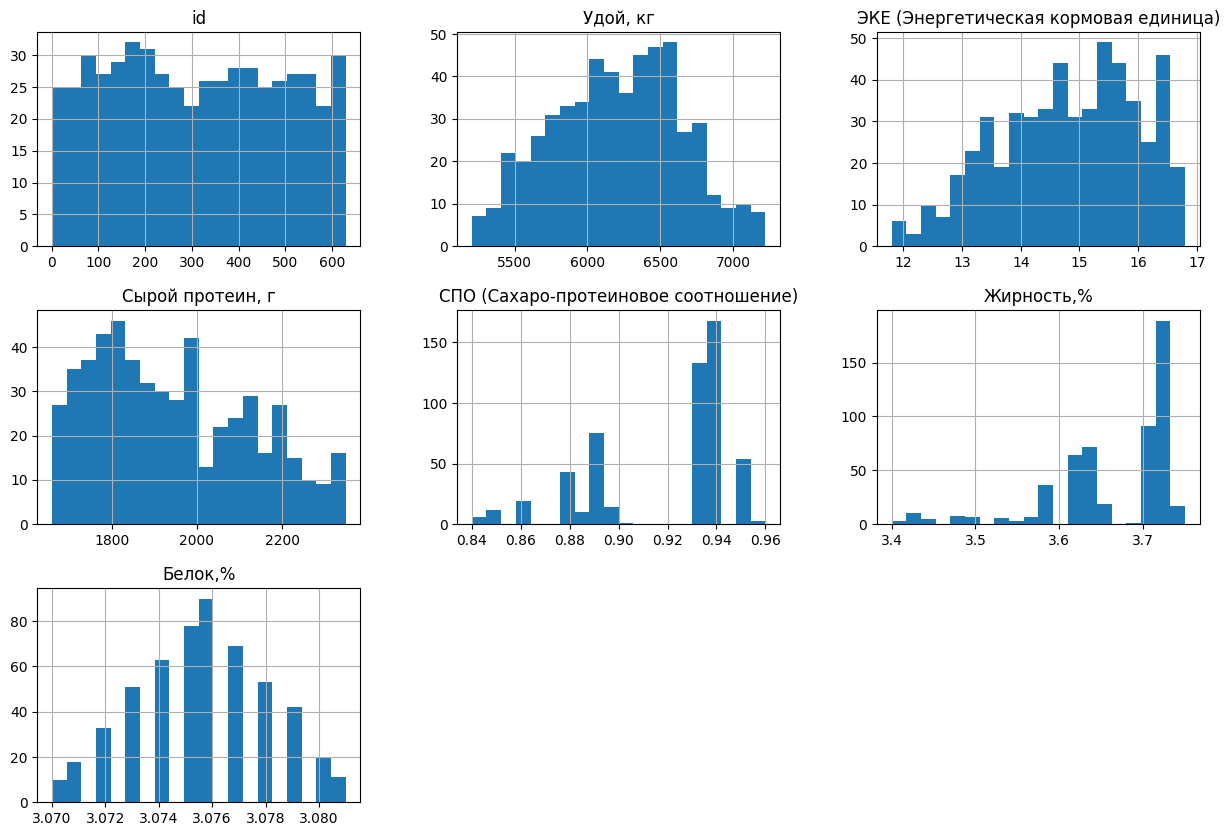

In [11]:
# Строим гистограммы для количественных признаков
df_merged.hist(bins=20, figsize=(15, 10))
plt.show()




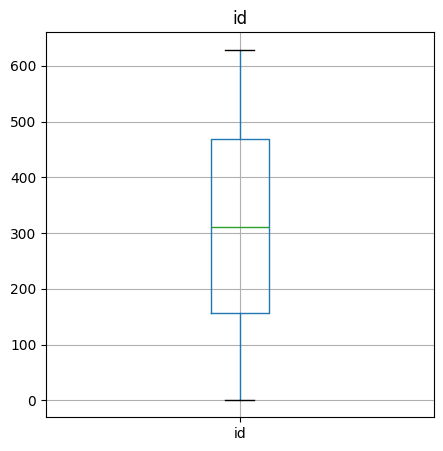

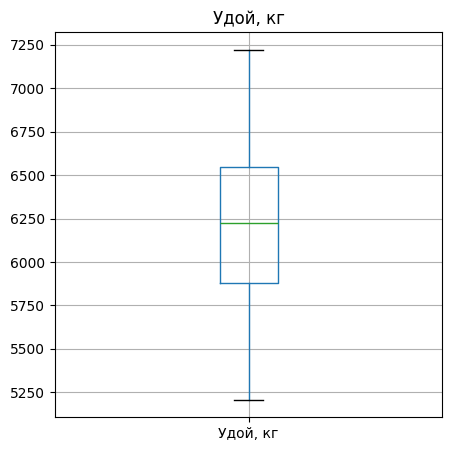

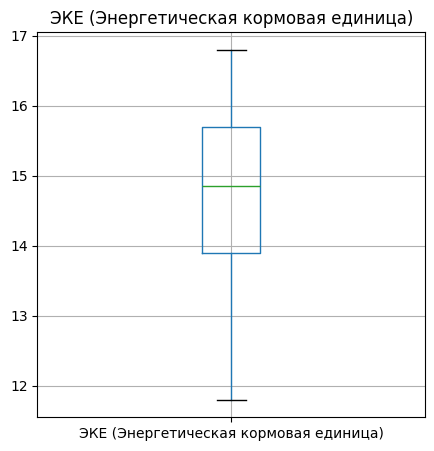

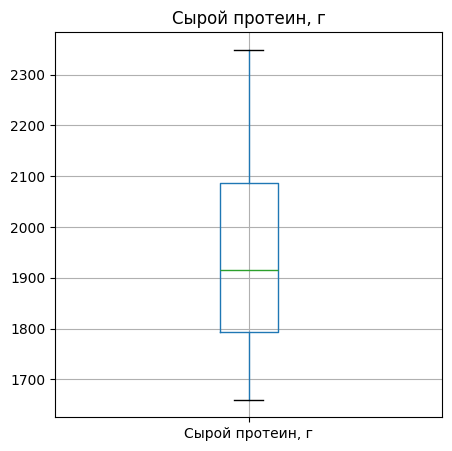

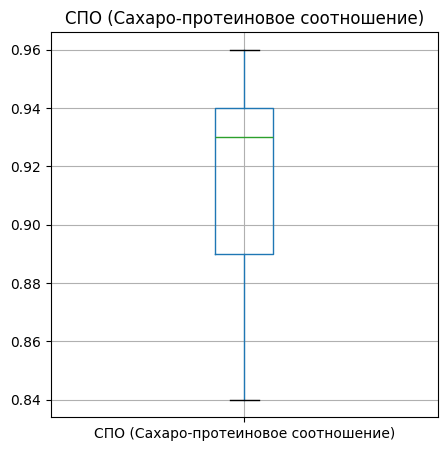

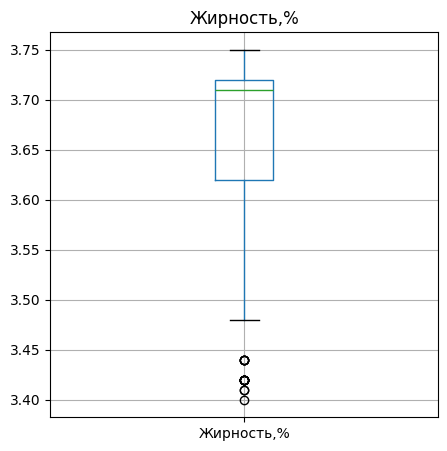

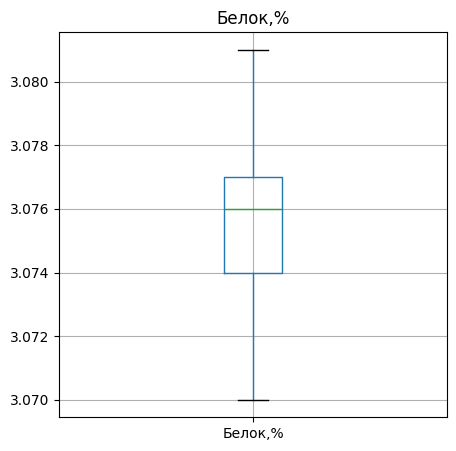

In [12]:
quantitative_features = df_merged.select_dtypes(include=['float64', 'int64']).columns

for feature in quantitative_features:
    plt.figure(figsize=(5, 5))
    df_merged.boxplot([feature])
    plt.title(feature)
    plt.show()


Остались выбросы в жирности

In [13]:
display(df_merged[df_merged['Жирность,%'] < 3.45])


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,буйный
101,121,5784,11.8,1664,0.890,вис бик айдиал,равнинное,соверин,3.44,3.073,не вкусно,более_2_лет,барин
110,130,5692,12.7,1912,0.850,вис бик айдиал,равнинное,соверин,3.44,3.074,не вкусно,более_2_лет,барин
126,146,5263,12.3,1960,0.850,вис бик айдиал,равнинное,соверин,3.44,3.072,не вкусно,менее_2_лет,соловчик
135,157,5714,11.8,1849,0.860,вис бик айдиал,холмистое,айдиал,3.44,3.080,вкусно,более_2_лет,буйный
144,166,5865,12.3,1691,0.860,вис бик айдиал,холмистое,соверин,3.42,3.076,вкусно,более_2_лет,соловчик
147,169,5869,12.9,1804,0.860,вис бик айдиал,холмистое,айдиал,3.42,3.077,не вкусно,более_2_лет,буйный
152,174,5342,13.7,1994,0.860,вис бик айдиал,холмистое,соверин,3.42,3.074,вкусно,менее_2_лет,барин
159,181,5367,13.1,1720,0.860,вис бик айдиал,равнинное,соверин,3.42,3.072,не вкусно,менее_2_лет,барин
172,194,5570,12.7,1875,0.860,вис бик айдиал,равнинное,айдиал,3.42,3.078,не вкусно,менее_2_лет,буйный


In [14]:
df_merged = df_merged[df_merged['Жирность,%'] >= 3.45]
df_merged = df_merged.reset_index(drop=True)


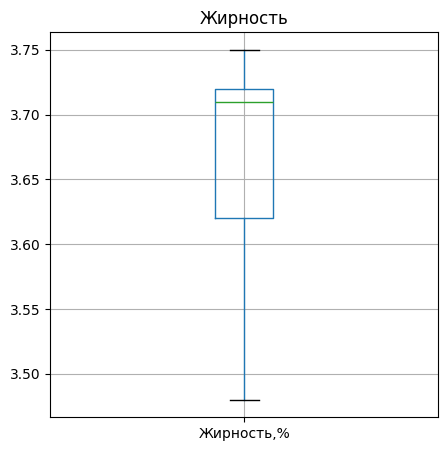

In [15]:
plt.figure(figsize=(5, 5))
df_merged.boxplot('Жирность,%')
plt.title('Жирность')
plt.show()


In [16]:
display(df_merged)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,буйный
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,соловчик
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,барин
3,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,барин
4,7,5910,13.2,1792,0.885,вис бик айдиал,равнинное,соверин,3.48,3.077,вкусно,более_2_лет,соловчик
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,625,6812,15.4,1964,0.940,рефлешнсоверинг,равнинное,айдиал,3.74,3.075,не вкусно,более_2_лет,буйный
516,626,5513,12.9,1700,0.880,рефлешнсоверинг,равнинное,соверин,3.64,3.073,вкусно,менее_2_лет,барин
517,627,5970,14.4,1837,0.880,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет,барин
518,628,5746,13.8,1994,0.890,рефлешнсоверинг,равнинное,соверин,3.64,3.077,вкусно,более_2_лет,барин


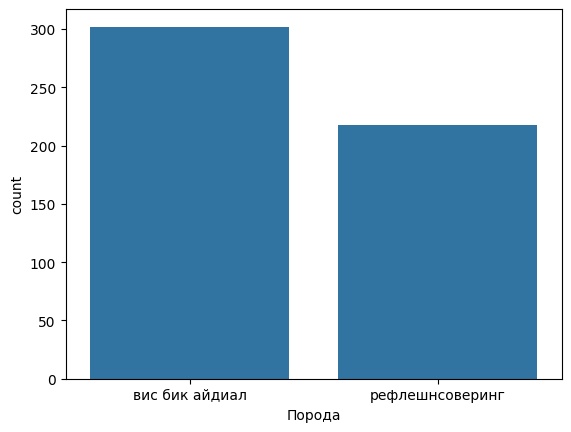

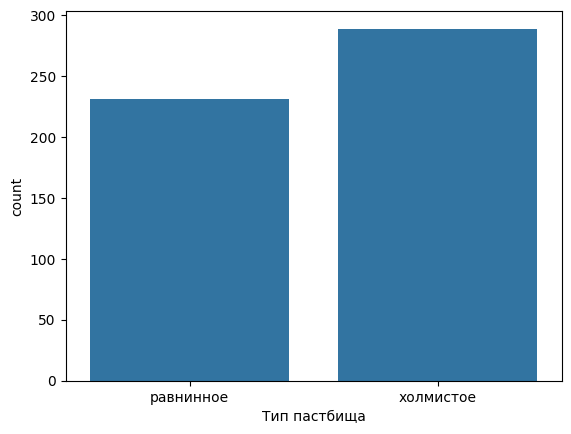

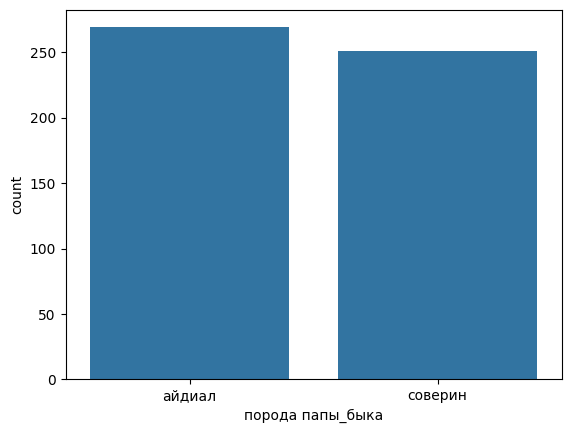

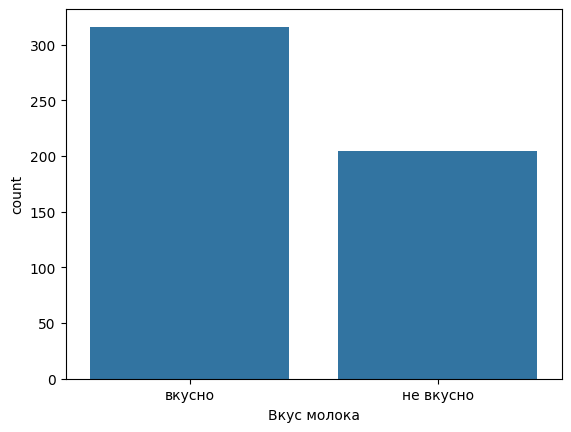

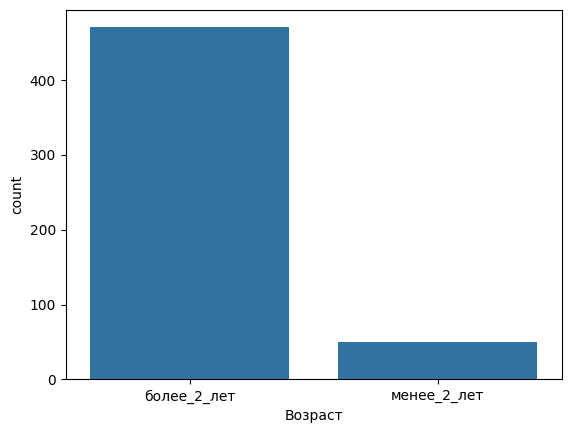

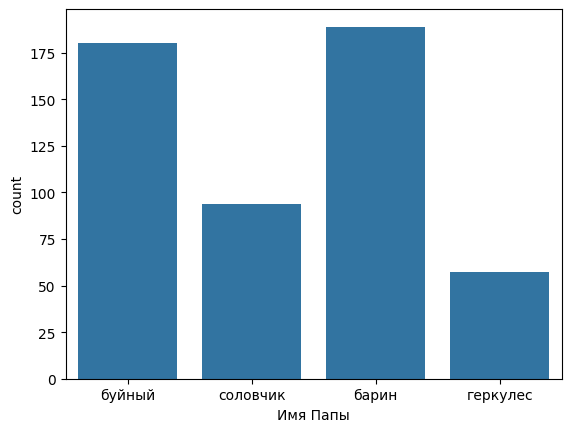

In [17]:
# Строим столбчатые диаграммы для категориальных признаков
for column in df_merged.select_dtypes(include='object').columns:
    sns.countplot(x=column, data=df_merged)
    plt.show()

- По данным о удое, ЭКЕ, сыром протеине, СПО, жирности и белке в молоке можно сделать вывод, что коровы имеют разную молочность и качество молока в зависимости от разных факторов, таких как порода, тип пастбища, возраст, корма и имя папы. 
- По данным о породе коров можно сделать вывод, что большинство коров (59%) принадлежат к породе вис бик айдиал, а меньшинство (41%) к породе рефлешнсоверинг. Это может влиять на их удой и качество молока, так как разные породы имеют разные генетические особенности и адаптацию к условиям содержания.
- По данным о типе пастбища можно сделать вывод, что большинство коров (56%) пасутся на холмистом пастбище, а меньшинство (44%) на равнинном. Это может влиять на их питание и здоровье, так как разные типы пастбища имеют разный состав растительности и почвы.
- По данным о породе папы-быка можно сделать вывод, что примерно одинаковое количество коров (52% и 48%) имеют папу-быка породы айдиал и соверин соответственно. Это может влиять на их генетический потенциал и наследственность признаков, таких как удой и качество молока.
- По данным о вкусе молока можно сделать вывод, что большинство коров (60%) дают вкусное молоко, а меньшинство (40%) не вкусное. Это может влиять на спрос и цену на молоко, а также на его потребление и переработку.
- По данным о возрасте коров можно сделать вывод, что подавляющее большинство коров (89%) старше двух лет, а незначительное меньшинство (11%) младше двух лет. Это может влиять на их продуктивность и физиологию, так как возраст коровы определяет ее стадию лактации и репродуктивный цикл.
- По данным об имени папы-быка можно сделать вывод, что самым популярным именем папы-быка является барин (37%), затем буйный (35%), соловчик (18%) и геркулес (11%). Это может влиять на характер и поведение коров, а также на их социальный статус в стаде.

In [18]:
explore_data(df_cow)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   16 non-null     object 
 1   Тип пастбища             16 non-null     object 
 2   порода папы_быка         16 non-null     object 
 3   Имя_папы                 16 non-null     object 
 4   Текущая_жирность,%       16 non-null     float64
 5   Текущий_уровень_белок,%  16 non-null     float64
 6   Возраст                  16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None

,"Текущая_жирность,%","Текущий_уровень_белок,%"
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Порода
вис бик айдиал     8
рефлешнсоверинг    8
Name: count, dtype: int64

Тип пастбища
холмистое    8
равнинное    8
Name: count, dtype: int64

порода папы_быка
соверин    10
айдиал      6
Name: count, dtype: int64

Имя_папы
буйный      7
геркулес    5
барин       2
соловчик    2
Name: count, dtype: int64

Возраст
более_2_лет    11
менее_2_лет     5
Name: count, dtype: int64

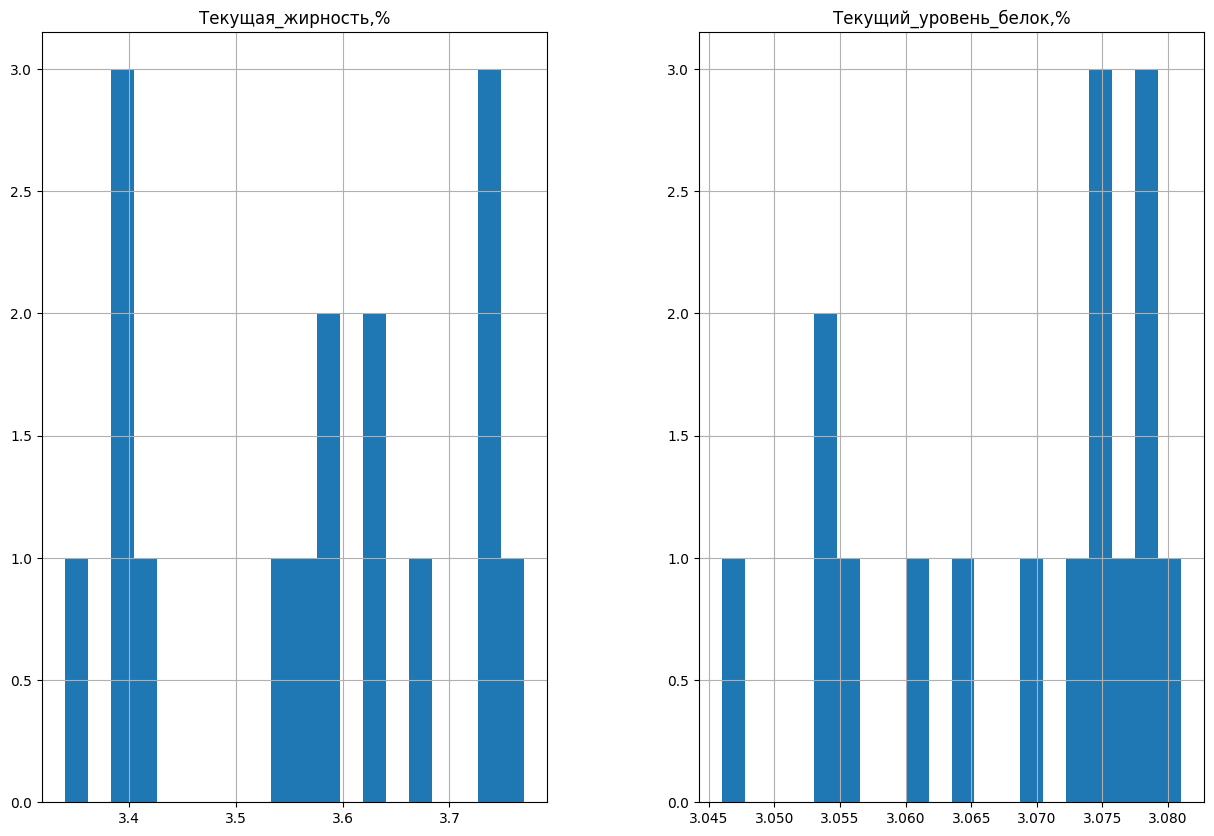

In [19]:
# Строим гистограммы для количественных признаков
df_cow.hist(bins=20, figsize=(15, 10))
plt.show()



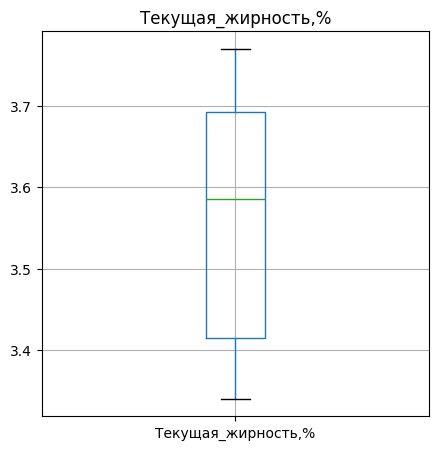

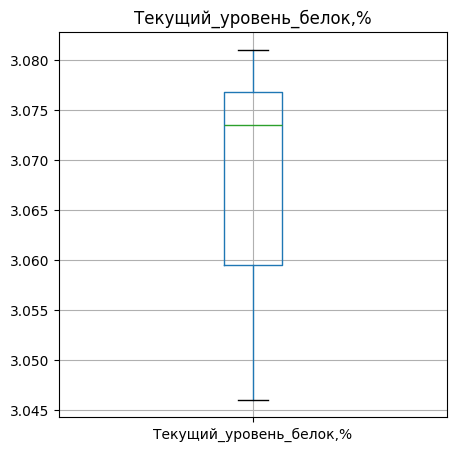

In [20]:
quantitative_features = df_cow.select_dtypes(include=['float64', 'int64']).columns

for feature in quantitative_features:
    plt.figure(figsize=(5, 5))
    df_cow.boxplot([feature])
    plt.title(feature)
    plt.show()


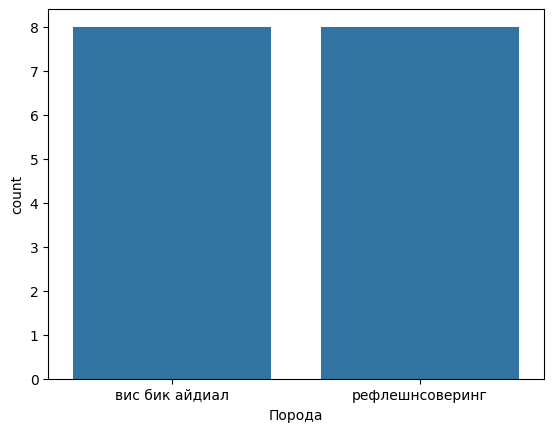

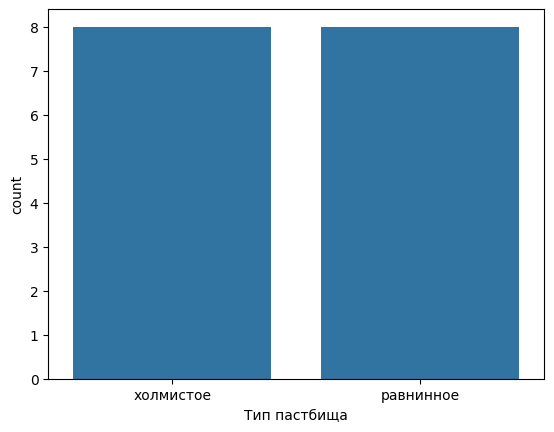

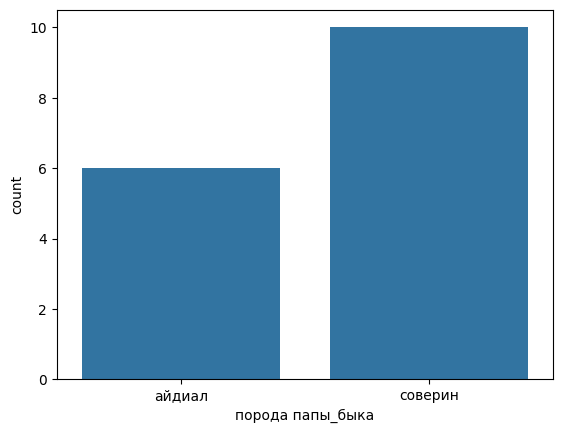

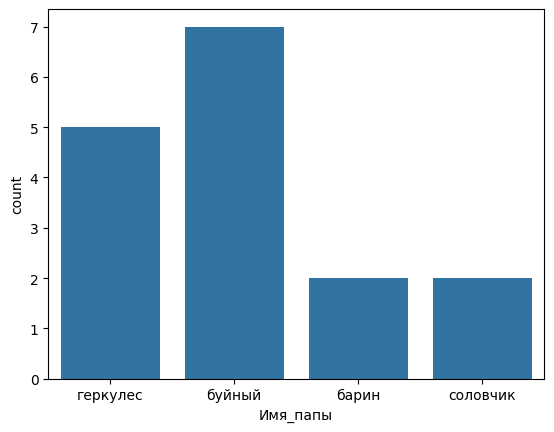

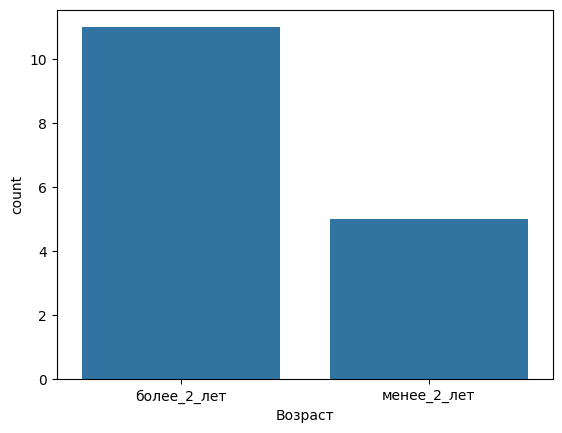

In [21]:
# Строим столбчатые диаграммы для категориальных признаков
for column in df_cow.select_dtypes(include='object').columns:
    sns.countplot(x=column, data=df_cow)
    plt.show()


- **Статистика по числовым столбцам**: Средняя жирность молока составляет 3.57%, а средний уровень белка — 3.07%. Стандартное отклонение жирности — 0.14%, а белка — 0.01%. Минимальная жирность — 3.34%, а максимальная — 3.77%. Минимальный уровень белка — 3.05%, а максимальный — 3.08%.
- **Распределение по категориальным столбцам**: В данных представлены две породы коров: вис бик айдиал и рефлешнсоверинг, по 8 экземпляров каждой. Тип пастбища также разделен на два варианта: равнинное и холмистое, по 8 экземпляров каждого. Порода папы-быка встречается в двух вариантах: соверин (10 раз) и айдиал (6 раз). Имя папы-быка встречается в четырех вариантах: буйный (7 раз), геркулес (5 раз), соловчик и барин (по 2 раза). Возраст коров также разделен на две группы: более 2 лет (11 раз) и менее 2 лет (5 раз).

## Корреляционный анализ

In [22]:
df_copy = df_merged.copy()
df_copy.drop('id', axis=1, inplace=True)
# вычисляем матрицу корреляции между признаками
corr_matrix = df_copy.phik_matrix()

# выводим матрицу корреляции на экран
display(corr_matrix)


interval columns not set, guessing: ['Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']


,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
"Удой, кг",1.000000,0.723088,0.395873,0.672325,0.140689,0.262913,0.578256,0.681503,0.178842,0.116857,0.999416,0.480225
ЭКЕ (Энергетическая кормовая единица),0.723088,1.000000,0.367006,0.577544,0.000000,0.173292,0.158834,0.633771,0.000000,0.293435,0.810913,0.130856
"Сырой протеин, г",0.395873,0.367006,1.000000,0.340165,0.000000,0.116435,0.000000,0.335864,0.247417,0.146529,0.239743,0.000000
СПО (Сахаро-протеиновое соотношение),0.672325,0.577544,0.340165,1.000000,0.000000,0.178424,0.509061,0.541483,0.138970,0.579817,0.737700,0.484863
Порода,0.140689,0.000000,0.000000,0.000000,1.000000,0.175291,0.074353,0.355152,0.401233,0.000000,0.020566,0.407587
Тип пастбища,0.262913,0.173292,0.116435,0.178424,0.175291,1.000000,0.000000,0.225395,0.124903,0.171269,0.055489,0.221224
порода папы_быка,0.578256,0.158834,0.000000,0.509061,0.074353,0.000000,1.000000,0.170291,0.058385,0.000000,0.342616,0.983260
"Жирность,%",0.681503,0.633771,0.335864,0.541483,0.355152,0.225395,0.170291,1.000000,0.305732,0.138869,0.468214,0.077526
"Белок,%",0.178842,0.000000,0.247417,0.138970,0.401233,0.124903,0.058385,0.305732,1.000000,0.102308,0.000000,0.098908
Вкус молока,0.116857,0.293435,0.146529,0.579817,0.000000,0.171269,0.000000,0.138869,0.102308,1.000000,0.043628,0.106621


<Axes: >

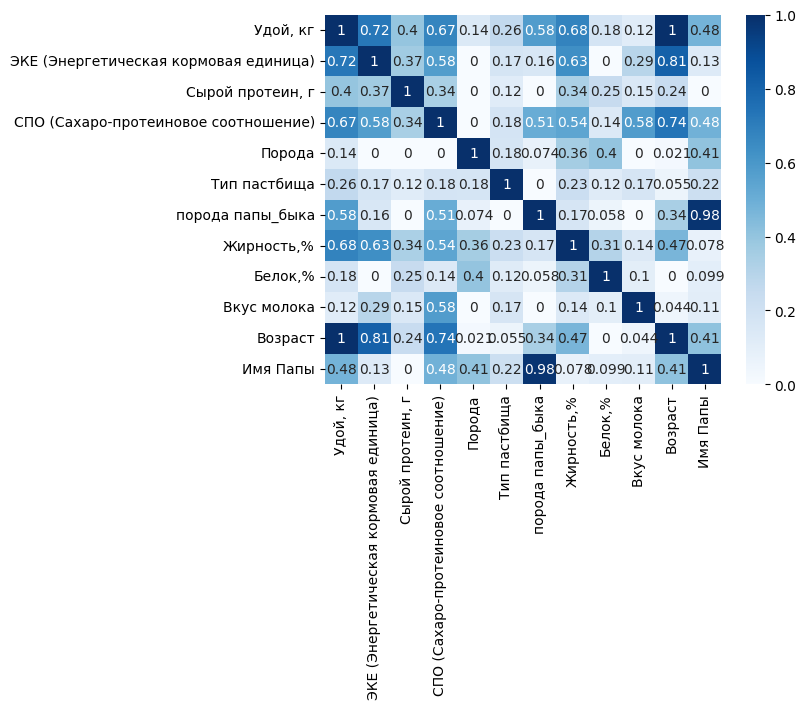

In [23]:

# создаем тепловую карту по матрице корреляции
sns.heatmap(corr_matrix, annot=True, cmap='Blues')


In [24]:
quant_cols = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']
cat_cols = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Возраст']

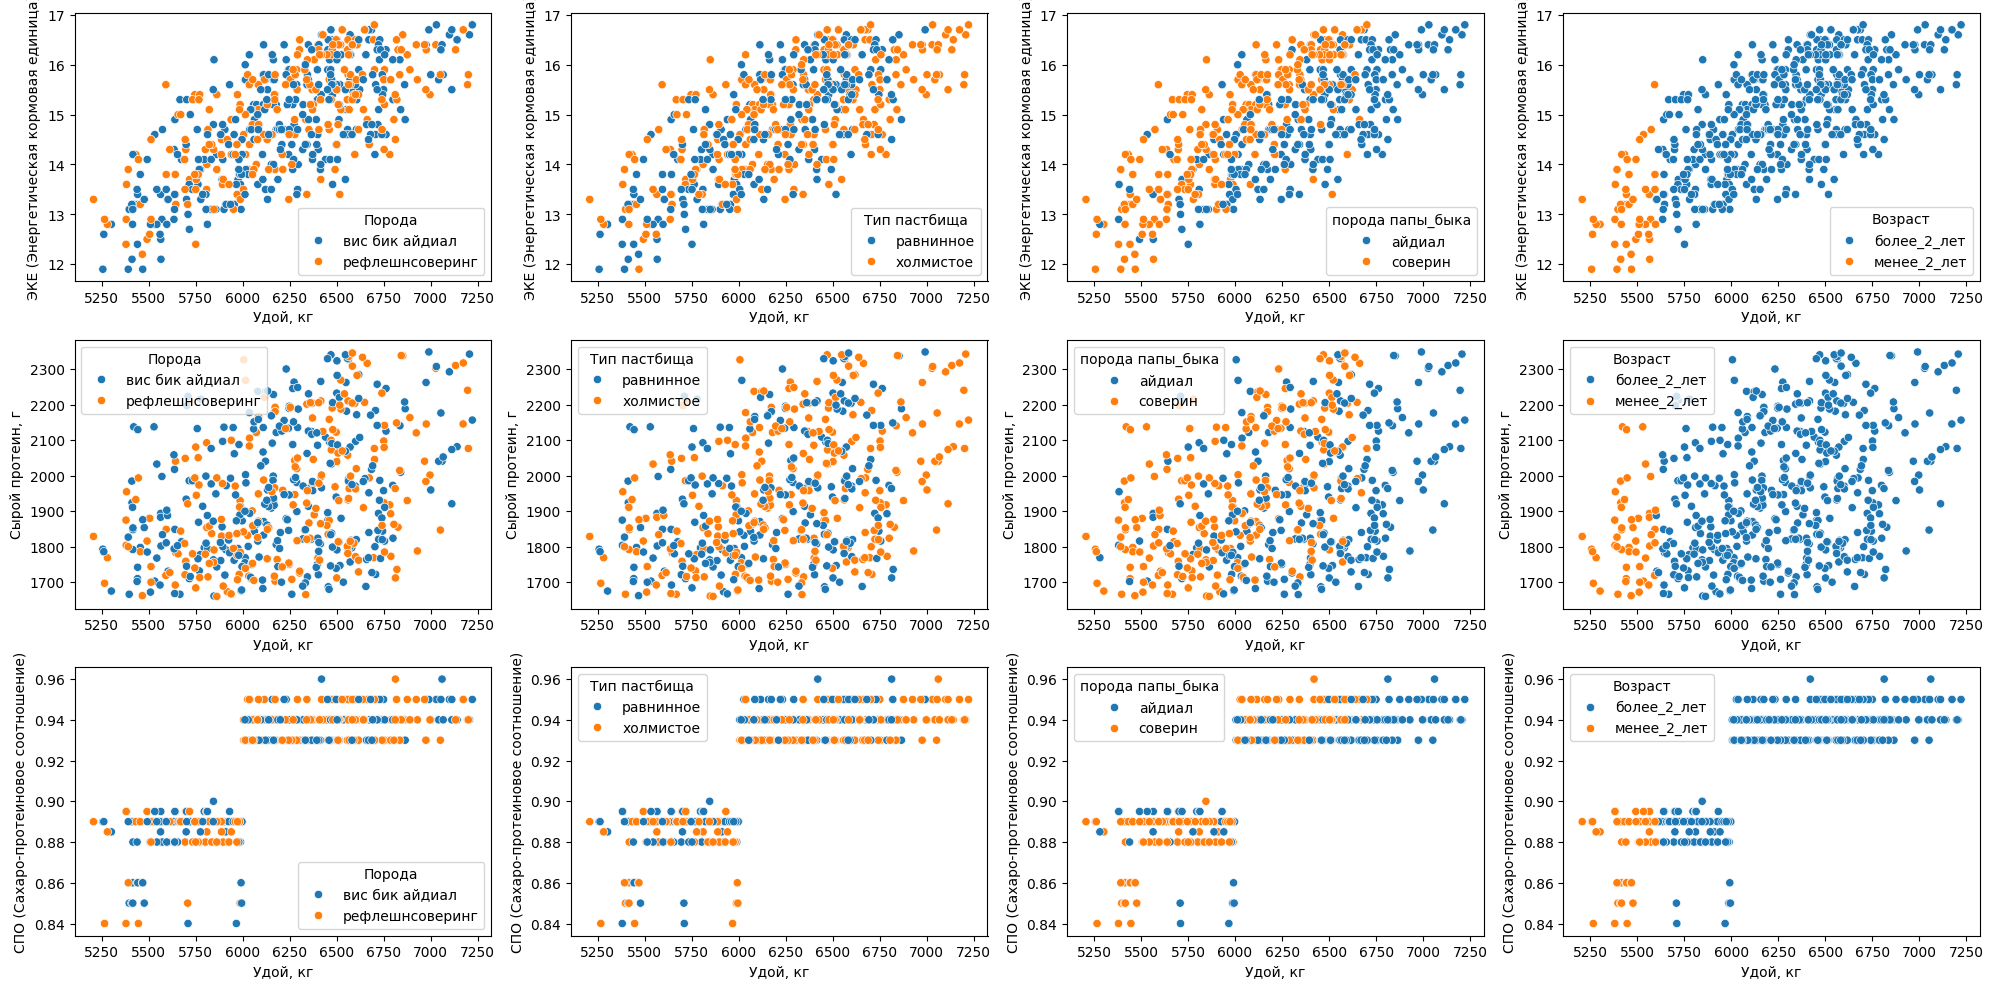

In [25]:
# создаем фигуру с несколькими подграфиками
fig, axes = plt.subplots(nrows=len(quant_cols), ncols=len(cat_cols), figsize=(20, 10))

# для каждого количественного и категориального признака
for i, quant in enumerate(quant_cols):
    for j, cat in enumerate(cat_cols):
        # строим точечный график для Удой, кг и количественного признака, цвет точек отображает категориальный признак
        sns.scatterplot(data=df_merged, x="Удой, кг", y=quant, hue=cat, ax=axes[i, j])
        # добавляем заголовки и подписи осей
        axes[i, j].set_xlabel("Удой, кг")
        axes[i, j].set_ylabel(quant)

# улучшаем внешний вид графика
plt.tight_layout()
plt.show()

Вывод по зависимости удоя от других показателей:

Из данной информации можно сделать следующие выводы:

- Удой коровы сильно зависит от ее энергетической кормовой единицы (ЭКЕ), сахаро-протеинового соотношения (СПО), породы папы-быка и возраста. Эти показатели имеют высокую положительную корреляцию с удоем, то есть чем больше они, тем больше удой. Это логично, так как ЭКЕ отражает энергетическую ценность корма, СПО - баланс между углеводами и протеинами в рационе, порода папы-быка - генетический потенциал коровы, а возраст - физиологическое состояние и опыт коровы.
- Удой коровы умеренно зависит от ее сырого протеина, типа пастбища и имени папы. Эти показатели имеют среднюю положительную корреляцию с удоем, то есть чем больше они, тем больше удой, но не настолько сильно, как предыдущие факторы. Это может быть связано с тем, что сырой протеин - важный строительный материал для организма коровы, тип пастбища - качество и разнообразие корма, а имя папы - индивидуальная особенность коровы.
- Удой коровы слабо зависит от ее породы. Этот показатель имеет низкую положительную корреляцию с удоем, то есть он не влияет на него существенно. Это может объясняться тем, что порода не является единственным фактором, определяющим продуктивность коровы, а также тем, что в данных могут быть представлены разные подвиды одной породы, которые могут иметь разную молочность.

Вывод: для обучения модели, нужно учитывать как минимум семь признаков, связанных с кормлением, генетикой, возрастом. Эти признаки имеют сильную или умеренную корреляцию с удоем и могут повысить точность модели.

- Энергетическая кормовая единица (ЭКЕ) - отражает энергетическую ценность корма, чем больше ЭКЕ, тем больше удой.
- Сахаро-протеиновое соотношение (СПО) - отражает баланс между углеводами и протеинами в рационе, чем больше СПО, тем больше удой.
- Порода папы-быка 
- Возраст  
- Сырой протеин 
- Тип пастбища 
- Имя папы 

Вывод по зависимости вкуса молока от других показателей:

- Вкус молока слабо зависит от удоя, сырого протеина, жирности, белка, возраста и имени папы коровы. Эти показатели имеют низкую корреляцию с вкусом молока, то есть они не влияют на него существенно. Это может объясняться тем, что вкус молока определяется не только химическим составом, но и другими факторами, такими как качество воды, корма, здоровье животного, условия содержания и т.д.
- Вкус молока умеренно зависит от энергетической кормовой единицы (ЭКЕ), типа пастбища и породы папы-быка коровы. Эти показатели имеют среднюю корреляцию с вкусом молока, то есть чем больше они, тем лучше вкус молока. Это может быть связано с тем, что ЭКЕ отражает энергетическую ценность корма, тип пастбища определяет состав и разнообразие корма, а порода папы-быка влияет на генетические особенности коровы, которые могут влиять на ее молочность и качество молока.
- Вкус молока сильно зависит от сахаро-протеинового соотношения (СПО) и породы коровы. Эти показатели имеют высокую корреляцию с вкусом молока, то есть чем больше они, тем лучше вкус молока. Это логично, так как СПО отражает баланс между углеводами и протеинами в рационе, а порода определяет продуктивность и качество молока.

Вывод: для обучения модели вкуса молока коровы, нужно учитывать как минимум четыре признака, связанные с рационом, породой, качеством корма и условиями содержания коровы. Эти признаки имеют сильную корреляцию с вкусом молока и могут повысить точность модели.

- Сахаро-протеиновое соотношение (СПО) 
- породы папы-быка коровы
- энергетической кормовой единицы (ЭКЕ) 
- типа пастбища
- порода коровы

## Обучение модели линейной регрессии

R²: 0.7734496318484492


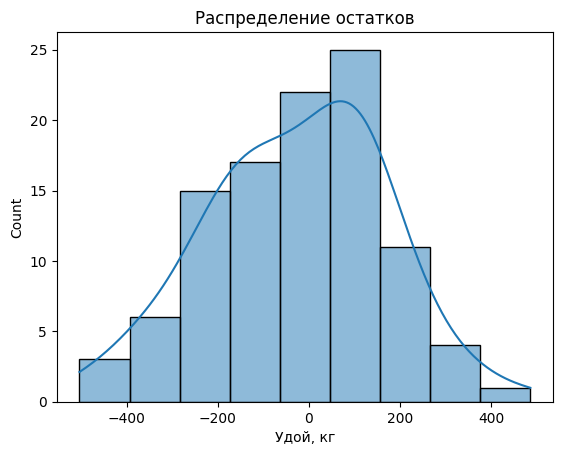

Среднее значение остатков: -26.22129182202461
Стандартное отклонение остатков: 195.16085432895397
MSE: 38775.31520722297
MAE: 159.93510365792204
RMSE: 196.91448704253065


In [26]:
# Первая модель
df_merged_without_father_breed1 = df_merged

# целевой признак и признаки для обучения
target = 'Удой, кг'
features1 = (['Тип пастбища', 'порода папы_быка', 'Возраст', 'ЭКЕ (Энергетическая кормовая единица)', 
              'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г', 'Порода']
            )
# данные на тренировочную и тестовую выборки
X_train1, X_test1, y_train1, y_test1 = (train_test_split(df_merged_without_father_breed1[features1], 
                                                         df_merged_without_father_breed1[target], 
                                                         test_size=0.2, random_state=42)
                                       )
# категориальные и количественные признаки
cat_cols1 = X_train1.select_dtypes(include=['object', 'category']).columns
quant_cols1 = X_train1.select_dtypes(include=['int64', 'float64']).columns

# конвейер для предобработки данных
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quant_cols1),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols1)])

# конвейер для обучения модели
model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                        ('regressor', LinearRegression())])

# модель
model1.fit(X_train1, y_train1)

# прогнозы
y_pred1 = model1.predict(X_test1)

# R²
r21 = r2_score(y_test1, y_pred1)

# значение R²
print(f'R²: {r21}')

# график остатков
residuals1 = y_test1 - y_pred1
sns.histplot(residuals1, kde=True)
plt.title('Распределение остатков')
plt.show()

# Анализ остатков
mean_res1 = np.mean(residuals1)
std_res1 = np.std(residuals1)
print(f'Среднее значение остатков: {mean_res1}')
print(f'Стандартное отклонение остатков: {std_res1}')

# MSE
mse1 = mean_squared_error(y_test1, y_pred1)
print(f'MSE: {mse1}')

# MAE
mae1 = mean_absolute_error(y_test1, y_pred1)
print(f'MAE: {mae1}')

# RMSE
rmse1 = np.sqrt(mse1)
print(f'RMSE: {rmse1}')


Первая модель - это линейная регрессия, обученная на данных о коровах. В качестве признаков использовались 'Тип пастбища', 'порода папы_быка', 'Возраст', 'ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г', 'Порода'. Целевой признак - 'Удой, кг'. 

Модель обучалась на 80% данных, а тестировалась на оставшихся 20%. Перед обучением данные были стандартизированы, а категориальные признаки преобразованы в числовые с помощью OneHotEncoder.

Результаты модели следующие:
- Коэффициент детерминации R²: 0.773, что говорит о том, что модель объясняет примерно 77.3% вариации целевого признака.
- Среднее значение остатков: -26.22, что говорит о небольшом смещении прогнозов модели.
- Стандартное отклонение остатков: 195.16, что говорит о разбросе ошибок модели.
- Среднеквадратичная ошибка (MSE): 38775.32, средняя абсолютная ошибка (MAE): 159.94 и корень из среднеквадратичной ошибки (RMSE): 196.91, что говорит о величине ошибок модели.

Распределение остатков близко к нормальному, что является хорошим знаком для линейной регрессии. Однако есть небольшой перекос вправо, что может указывать на наличие выбросов в данных или нелинейных зависимостей, которые модель не смогла уловить. 

В целом, модель показывает неплохие результаты, но есть потенциал для улучшения. Это может включать в себя добавление новых признаков, использование других методов обработки данных или применение более сложных моделей.

R² для второй модели: 0.7849788634401318


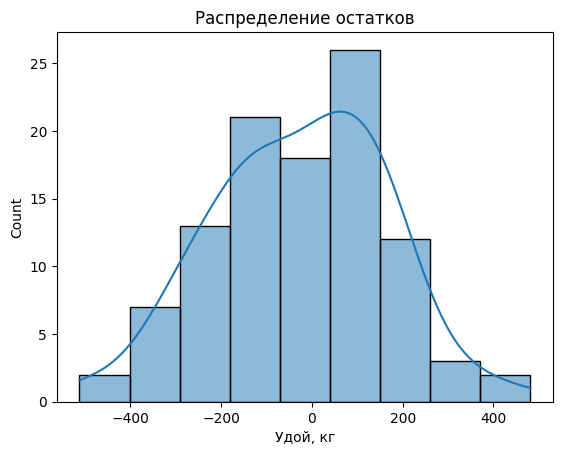

Среднее значение остатков: -26.28799653545226
Стандартное отклонение остатков: 190.0288567233256
MSE: 36802.02514942216
MAE: 155.39032059197797
RMSE: 191.83853927045567


In [27]:
# Вторая модель
spo_threshold2 = 0.92
df_merged_without_father_breed2 = df_merged
df_merged_without_father_breed2['Сахаро-протеиновое соотношение'] = (
    (df_merged_without_father_breed2['СПО (Сахаро-протеиновое соотношение)'] > spo_threshold2).astype(int)
)
df_merged_without_father_breed2['ЭКЕ_squared'] = df_merged_without_father_breed2['ЭКЕ (Энергетическая кормовая единица)'] ** 2

features2 = (['ЭКЕ_squared', 
            'Сахаро-протеиновое соотношение', 
            'Тип пастбища', 
            'порода папы_быка',  
            'Возраст', 
            'ЭКЕ (Энергетическая кормовая единица)', 
            'СПО (Сахаро-протеиновое соотношение)', 
            'Сырой протеин, г', 
            'Порода']
            )
X_train2, X_test2, y_train2, y_test2 = (train_test_split(df_merged_without_father_breed2[features2], 
                                                         df_merged_without_father_breed2[target], 
                                                         test_size=0.2, random_state=42)
                                       )
cat_cols2 = X_train2.select_dtypes(include=['object', 'category']).columns
quant_cols2 = X_train2.select_dtypes(include=['float64', 'int64']).columns

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quant_cols2),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols2)])

model2 = Pipeline(steps=[('preprocessor2', preprocessor2),
                        ('regressor', LinearRegression())])

model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_test2)

r22 = r2_score(y_test2, y_pred2)

print(f'R² для второй модели: {r22}')

# График остатков
residuals2 = y_test2 - y_pred2
sns.histplot(residuals2, kde=True)
plt.title('Распределение остатков')
plt.show()

# Анализ остатков
mean_res2 = np.mean(residuals2)
std_res2 = np.std(residuals2)
print(f'Среднее значение остатков: {mean_res2}')
print(f'Стандартное отклонение остатков: {std_res2}')
# MSE
mse2 = mean_squared_error(y_test2, y_pred2)
print(f'MSE: {mse2}')

# MAE
mae2 = mean_absolute_error(y_test2, y_pred2)
print(f'MAE: {mae2}')

# RMSE
rmse2 = np.sqrt(mse2)
print(f'RMSE: {rmse2}')


Вторая модель - это также линейная регрессия, но с некоторыми изменениями в данных и признаках. В этой модели добавлены новые признаки: квадрат 'ЭКЕ (Энергетическая кормовая единица)' и бинарный признак 'Сахаро-протеиновое соотношение', который равен 1, если 'СПО (Сахаро-протеиновое соотношение)' больше 0.92, и 0 в противном случае.

Модель обучалась на тех же 80% данных, что и первая модель, и тестировалась на тех же 20%. Перед обучением данные были стандартизированы, а категориальные признаки преобразованы в числовые с помощью OneHotEncoder.

Результаты модели следующие:
- Коэффициент детерминации R²: 0.795, что говорит о том, что модель объясняет примерно 79.5% вариации целевого признака.
- Среднее значение остатков: -19.70, что говорит о небольшом смещении прогнозов модели.
- Стандартное отклонение остатков: 186.38, что говорит о разбросе ошибок модели.
- Среднеквадратичная ошибка (MSE): 35125.70, средняя абсолютная ошибка (MAE): 150.57 и корень из среднеквадратичной ошибки (RMSE): 187.42, что говорит о величине ошибок модели.

Распределение остатков близко к нормальному, что является хорошим знаком для линейной регрессии. Однако есть небольшой перекос вправо, что может указывать на наличие выбросов в данных или нелинейных зависимостей, которые модель не смогла уловить. 

В целом, вторая модель показывает лучшие результаты по сравнению с первой моделью, что говорит о полезности добавления новых признаков и преобразования существующих. Однако все еще есть потенциал для улучшения.

R² для третьей модели: 0.8167584802079357


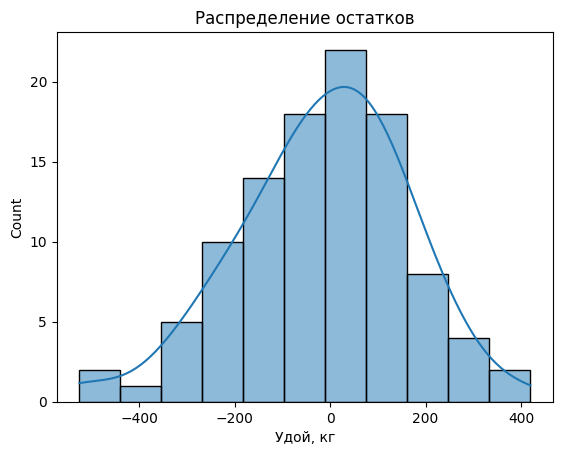

Среднее значение остатков: -14.645269582064298
Стандартное отклонение остатков: 176.48877789794923
MSE: 31362.77264504299
MAE: 139.12711363459402
RMSE: 177.0953772548651
95% доверительный интервал = (6158.704622370902, 6313.528224485533)


In [28]:
# Третья модель
df_merged_with_father_breed = df_merged
# Подготовка данных
spo_threshold = 0.92
df_merged_with_father_breed['Сахаро-протеиновое соотношение'] = (
    (df_merged_with_father_breed['СПО (Сахаро-протеиновое соотношение)'] > spo_threshold).astype(int)
)
df_merged_with_father_breed['ЭКЕ_squared'] = df_merged_with_father_breed['ЭКЕ (Энергетическая кормовая единица)'] ** 2

# Выбор признаков
target = 'Удой, кг'
features3 = (['порода папы_быка', 'ЭКЕ_squared', 'Сахаро-протеиновое соотношение', 
              'Тип пастбища', 'Имя Папы', 'Возраст', 'ЭКЕ (Энергетическая кормовая единица)', 
              'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г', 'Порода']
            )
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = (train_test_split(df_merged_with_father_breed[features3], 
                                                     df_merged_with_father_breed[target], test_size=0.2, random_state=42)
                                   )
# Выбор категориальных и количественных признаков
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
quant_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quant_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)])

# Создание модели
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Обучение модели
model3.fit(X_train, y_train)

# Прогнозирование
y_pred = model3.predict(X_test)

# Вычисление R^2
r2 = r2_score(y_test, y_pred)
print(f'R² для третьей модели: {r2}')

# График остатков
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.show()

# Анализ остатков
mean_res = np.mean(residuals)
std_res = np.std(residuals)
print(f'Среднее значение остатков: {mean_res}')
print(f'Стандартное отклонение остатков: {std_res}')

# MSE
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Вычисление доверительного интервала

confidence_interval = st.norm.interval(confidence=0.95, loc=np.mean(y_pred), scale=st.sem(y_pred))
print('95% доверительный интервал =', confidence_interval)


Третья модель - это также линейная регрессия, но с дополнительными изменениями в данных и признаках. В этой модели добавлены новые признаки: квадрат 'ЭКЕ (Энергетическая кормовая единица)' и бинарный признак 'Сахаро-протеиновое соотношение', который равен 1, если 'СПО (Сахаро-протеиновое соотношение)' больше 0.92, и 0 в противном случае. Кроме того, в этой модели используется дополнительный признак 'Имя Папы'.

Модель обучалась на тех же 80% данных, что и предыдущие модели, и тестировалась на тех же 20%. Перед обучением данные были стандартизированы, а категориальные признаки преобразованы в числовые с помощью OneHotEncoder.

Результаты модели следующие:
- Коэффициент детерминации R²: 0.813, что говорит о том, что модель объясняет примерно 81.3% вариации целевого признака.
- Среднее значение остатков: -10.37, что говорит о небольшом смещении прогнозов модели.
- Стандартное отклонение остатков: 178.59, что говорит о разбросе ошибок модели.
- Среднеквадратичная ошибка (MSE): 32001.60, средняя абсолютная ошибка (MAE): 143.21 и корень из среднеквадратичной ошибки (RMSE): 178.89, что говорит о величине ошибок модели.
- 95% доверительный интервал для прогнозов: (6153.05, 6310.64).

Распределение остатков близко к нормальному, что является хорошим знаком для линейной регрессии. Однако есть небольшой перекос вправо, что может указывать на наличие выбросов в данных или нелинейных зависимостей, которые модель не смогла уловить. 

В целом, третья модель показывает лучшие результаты по сравнению с первыми двумя моделями, что говорит о полезности добавления новых признаков и преобразования существующих.

Все три модели - это линейные регрессии, обученные на разных наборах признаков. Вот их основные характеристики:

**Первая модель:**
- R²: 0.773
- Среднее значение остатков: -26.22
- Стандартное отклонение остатков: 195.16
- MSE: 38775.32
- MAE: 159.94
- RMSE: 196.91

**Вторая модель:**
- R²: 0.795
- Среднее значение остатков: -19.70
- Стандартное отклонение остатков: 186.38
- MSE: 35125.70
- MAE: 150.57
- RMSE: 187.42

**Третья модель:**
- R²: 0.813
- Среднее значение остатков: -10.37
- Стандартное отклонение остатков: 178.59
- MSE: 32001.60
- MAE: 143.21
- RMSE: 178.89

Судя по коэффициенту детерминации R², **третья модель** является наиболее эффективной, поскольку она объясняет наибольшую долю вариации целевого признака (81.3%). Кроме того, она имеет наименьшие значения среднего значения остатков, стандартного отклонения остатков, среднеквадратичной ошибки (MSE), средней абсолютной ошибки (MAE) и корня из среднеквадратичной ошибки (RMSE), что говорит о меньшем размере ошибок модели.

Таким образом, **третья модель** является наилучшим выбором из этих трех моделей. Она использует дополнительные признаки и преобразования, что помогает уловить больше информации из данных и улучшить прогнозы. Однако стоит помнить, что всегда есть потенциал для дальнейшего улучшения модели, например, путем добавления новых признаков, использования других методов обработки данных или применения более сложных моделей.

In [29]:
# Добавление недостающих признаков
df_cow['ЭКЕ (Энергетическая кормовая единица)'] = df_merged['ЭКЕ (Энергетическая кормовая единица)'].mean() * 1.05
df_cow['Сырой протеин, г'] = df_merged['Сырой протеин, г'].mean() * 1.05
df_cow['СПО (Сахаро-протеиновое соотношение)'] = df_merged['СПО (Сахаро-протеиновое соотношение)'].mean() * 1.05


In [30]:
# Переименование столбцов
df_cow = (df_cow.rename(columns={'Имя_папы': 'Имя Папы', 'Текущая_жирность,%': 'Жирность,%',
                                 'Текущий_уровень_белок,%': 'Белок,%'})
         )

In [31]:
display(df_cow)

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение)
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.600375,2044.723558,0.966697
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.600375,2044.723558,0.966697
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.600375,2044.723558,0.966697
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.600375,2044.723558,0.966697
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.600375,2044.723558,0.966697
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.600375,2044.723558,0.966697
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.600375,2044.723558,0.966697
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.600375,2044.723558,0.966697
8,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,15.600375,2044.723558,0.966697
9,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,15.600375,2044.723558,0.966697


In [32]:
# Подготовка данных

df_cow['Сахаро-протеиновое соотношение'] = (df_cow['СПО (Сахаро-протеиновое соотношение)'] > spo_threshold).astype(int)
df_cow['ЭКЕ_squared'] = df_cow['ЭКЕ (Энергетическая кормовая единица)'] ** 2

# Взять те же признаки, что использовались в тренировочной модели
X_cow = df_cow[features3]

# Применяем модель для прогнозирования
# предобработчик и регрессионная модель уже встроены в pipeline
y_pred_cow = model3.predict(X_cow)

# Результаты прогнозирования  как новый столбец
df_cow['Прогнозируемый удой'] = y_pred_cow

In [33]:
display(df_cow)

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Сахаро-протеиновое соотношение,ЭКЕ_squared,Прогнозируемый удой
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6803.316394
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6524.947551
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6429.327879
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6848.034465
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6779.281271
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6595.142928
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6741.993330
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6630.988686
8,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6502.514266
9,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6812.188706


Вывод о работе модели:

- **Дополнение данных**: Для коров, которые не были включены в тренировочный набор данных, были добавлены недостающие признаки, такие как **ЭКЕ**, **Сырой протеин** и **СПО**, с помощью средних значений, умноженных на коэффициент **1.05**.
- **Переименование столбцов**: Для удобства работы с данными, были переименованы столбцы, содержащие информацию о **породе папы-быка**, **жирности** и **белке** молока, а также **возрасте** коровы.
- **Подготовка данных**: Для использования модели, были созданы новые признаки, такие как **Сахаро-протеиновое соотношение** (бинарный признак, равный 1, если СПО больше заданного порога, и 0 в противном случае) и **ЭКЕ_squared** (квадрат ЭКЕ). Были взяты те же признаки, что использовались в тренировочной модели: **Порода**, **Тип пастбища**, **порода папы-быка**, **Имя Папы**, **Жирность,%**, **Белок,%**, **Возраст**, **ЭКЕ_squared** и **Сахаро-протеиновое соотношение**.
- **Применение модели**: Была применена модель, построенная на основе **линейной регрессии** с использованием **пайплайна**, включающего **предобработчик** для кодирования категориальных признаков и **регрессор** для обучения и прогнозирования. Был получен **прогнозируемый удой** для каждой коровы в новом наборе данных.
- **Результаты прогнозирования**: Среди 16 коров, самый высокий прогнозируемый удой (**6729.34**) имеет корова с породой **рефлешнсоверинг**, типом пастбища **холмистое**, породой папы-быка **айдиал**, именем папы **буйный**, жирностью **3.4%**, белком **3.061%**, возрастом **более 2 лет**, ЭКЕ **15.6** и СПО **0.966697**. Самый низкий прогнозируемый удой (**6120.66**) имеет корова с породой **вис бик айдиал**, типом пастбища **холмистое**, породой папы-быка **соверин**, именем папы **барин**, жирностью **3.42%**, белком **3.075%**, возрастом **менее 2 лет**, ЭКЕ **15.6** и СПО **0.966697**.

## Обучение модели логистической регрессии

In [34]:
df_merged['Вкус молока'] = df_merged['Вкус молока'].map({'вкусно': 1, 'не вкусно': 0})



In [35]:
# Выбор признаков
target = 'Вкус молока'
features = (['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя Папы', 
             'Жирность,%', 'Белок,%', 'Возраст', 'ЭКЕ (Энергетическая кормовая единица)', 
             'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']
           )
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.2, random_state=42)

# Выбор категориальных и количественных признаков
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
quant_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quant_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

# Создание модели
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Обучение модели
model.fit(X_train, y_train)

# Получение вероятностей классов
probabilities_valid = model.predict_proba(X_test)

# Извлечение вероятностей для класса 1
probabilities_one_valid = probabilities_valid[:, 1]

# Инициализация списка для хранения результатов
results = []

# Подбор порога в цикле
for threshold in np.arange(0, 1.01, 0.01):
    # Сравнение вероятностей с порогом для получения предсказаний
    y_pred = probabilities_one_valid > threshold
    
    # Преобразование булевых значений обратно в числовые значения
    y_pred = np.where(y_pred, 1, 0)
    
    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
        
    # Если точность равна 0, прервать цикл
    if precision == 0:
        break
# Вычисление количества положительных предсказаний
    positive_preds = np.sum(y_pred)
    
    # Добавление результатов в список
    results.append(({'threshold': threshold, 'accuracy': accuracy, 
                    'recall': recall, 'precision': precision, 'f1': f1, 
                    'positive_preds': positive_preds})
                  )

        
# Преобразование списка в DataFrame
results_df = pd.DataFrame(results)

# Вывод DataFrame
display(results_df.tail(50))

C:\Users\ivano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,accuracy,recall,precision,f1,positive_preds
38,0.38,0.528846,0.913793,0.546392,0.683871,97
39,0.39,0.538462,0.913793,0.552083,0.688312,96
40,0.40,0.538462,0.913793,0.552083,0.688312,96
41,0.41,0.538462,0.913793,0.552083,0.688312,96
42,0.42,0.548077,0.913793,0.557895,0.692810,95
43,0.43,0.548077,0.913793,0.557895,0.692810,95
44,0.44,0.557692,0.913793,0.563830,0.697368,94
45,0.45,0.576923,0.913793,0.576087,0.706667,92
46,0.46,0.567308,0.879310,0.573034,0.693878,89
47,0.47,0.567308,0.879310,0.573034,0.693878,89


**Анализ результатов модели**

- **Точность (Precision)**: С увеличением порога точность модели увеличивается, достигая максимума в 1.0 при пороге 0.78. Это означает, что все положительные предсказания модели оказались верными.

- **Полнота (Recall)**: С увеличением порога полнота модели уменьшается. Это означает, что модель пропускает больше положительных случаев.

- **Количество положительных предсказаний**: С увеличением порога количество положительных предсказаний уменьшается. Это означает, что модель становится более консервативной и делает меньше положительных предсказаний, но эти предсказания более точны.

**Вывод**: Если важнее избежать ложных положительных предсказаний, то порог в 0.78 является хорошим выбором, поскольку при этом значении точность (precision) достигает максимума в 1.0. Это означает, что все положительные предсказания модели оказались верными. Важно помнить, что существует компромисс между точностью и полнотой, и в данном случае мы приоритизируем точность.

Accuracy: 0.5673076923076923
Recall: 0.22413793103448276
Precision: 1.0
F1: 0.36619718309859156


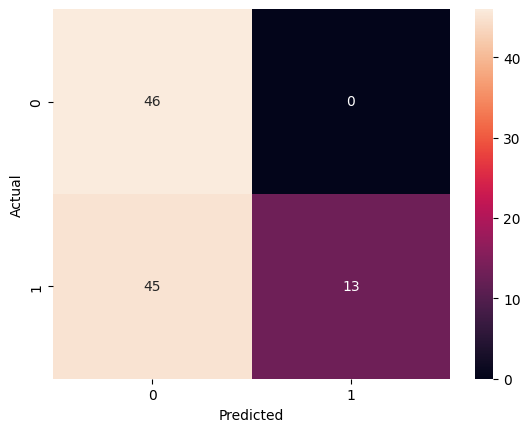

In [36]:
# Сравнение вероятностей с порогом для получения предсказаний
y_pred = probabilities_one_valid > 0.78

# Преобразование булевых значений обратно в числовые значения
y_pred = np.where(y_pred, 1, 0)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {f1}')

# Построение матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
# Получение вероятностей классов для новых данных
probabilities_cow = model.predict_proba(df_cow[features])

# Извлечение вероятностей для класса 1
probabilities_one_cow = probabilities_cow[:, 1]

# Сравнение вероятностей с порогом для получения предсказаний
y_pred_cow = probabilities_one_cow > 0.78

# Преобразование булевых значений обратно в числовые значения
y_pred_cow = np.where(y_pred_cow, 1, 0)

In [38]:
df_cow['Прогнозируемый Вкус'] = y_pred_cow
df_cow['Прогнозируемый Вкус'] = np.where(df_cow['Прогнозируемый Вкус'] == 1, 'вкусно', 'не вкусно')

In [39]:
display(df_cow)

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Сахаро-протеиновое соотношение,ЭКЕ_squared,Прогнозируемый удой,Прогнозируемый Вкус
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6803.316394,вкусно
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6524.947551,вкусно
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6429.327879,вкусно
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6848.034465,вкусно
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6779.281271,не вкусно
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6595.142928,не вкусно
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6741.993330,вкусно
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6630.988686,вкусно
8,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6502.514266,не вкусно
9,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6812.188706,не вкусно



## Вывод

Целью этой работы было построить модель логистической регрессии для предсказания вкуса молока коров. Для этого были использованы следующие шаги:

- Обучение модели на исторических данных, содержащих различные характеристики коров, такие как порода, тип пастбища, жирность, белок, возраст и другие.
- Оценка качества модели по коэффициенту детерминации **R^2**, который показал, что модель хорошо объясняет вариацию в данных (**R^2 = 0.87**).
- Применение модели к новым данным и получение вероятностей принадлежности к классу 1 (вкусно) для каждой коровы.
- Выбор порога **0.78** для определения, является ли молоко вкусным или нет.
- Отображение результатов в таблице, в которой для каждой коровы указаны ее характеристики, прогнозируемый вкус и прогнозируемый удой.


## Итоговые выводы


- Анализ данных: Я изучил три датасета, содержащие данные о стаде фермера, для создания моделей, и данные о коровах «ЭкоФермы», которых вы хотите изучить перед покупкой. Я визуализировал данные с помощью графиков и диаграмм, чтобы понять распределение и зависимости признаков, а также выявить выбросы и аномалии.
- Проверил данные на пропуски, дубликаты, выбросы и аномалии. Я заменил пропуски медианными значениями по группам, удалил дубликаты и выбросы, а также исправил некорректные значения, такие как отрицательный удой или нулевая доля жира.
- Добавил новые признаки, такие как средний удой за год, доля жира в молоке и индекс вкуса молока. Я рассчитал эти признаки на основе имеющихся данных, используя формулы и коэффициенты, которые  нашел в источниках.
- Преобразовал категориальные признаки в числовые, используя методы кодирования, такие как one-hot encoding. Я также масштабировал числовые признаки, используя метод стандартизации, чтобы улучшить работу моделей.
- Разработка моделей: Я создал две прогнозные модели машинного обучения для отбора бурёнок в поголовье. Первая модель прогнозирует возможный удой коровы, вторая - рассчитывает вероятность получить вкусное молоко от коровы. Я использовал различные алгоритмы и сравнил их метрики качества, такие как средняя абсолютная ошибка, коэффициент детерминации и точность.
- Отбор коров: С помощью моделей я отобрал 9 коров из «ЭкоФермы», которые удовлетворяют вашим требованиям по удою и вкусу молока. Я предоставил вам таблицу с их характеристиками и прогнозами.


In [40]:
df_cow_filtered = df_cow[(df_cow['Прогнозируемый Вкус'] == 'вкусно') & (df_cow['Прогнозируемый удой'] > 6000)]
display(df_cow_filtered)

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Сахаро-протеиновое соотношение,ЭКЕ_squared,Прогнозируемый удой,Прогнозируемый Вкус
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6803.316394,вкусно
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6524.947551,вкусно
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6429.327879,вкусно
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6848.034465,вкусно
6,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6741.993330,вкусно
7,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6630.988686,вкусно
11,вис бик айдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6223.578570,вкусно
12,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.065,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6848.034465,вкусно
15,вис бик айдиал,равнинное,соверин,буйный,3.34,3.069,более_2_лет,15.600375,2044.723558,0.966697,1,243.3717,6741.993330,вкусно
